In [1]:
import typing
from scipy.sparse import spmatrix, csr_matrix
import torch
import torchvision
from scipy.spatial.distance import squareform
import scipy
from numba import jit
import numpy as np
from matplotlib import pyplot as plt
import functools
from sklearn.decomposition import PCA

import paradime as prdm
from paradime.paradime import NegSampledEdgeDataset
from paradime.paradime import _collate_edge_batch

In [2]:
mnist = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
num_pts = 5000
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:num_pts][np.argsort(mnist.targets[:num_pts])]
testtargets = np.sort(mnist.targets[:num_pts])

In [4]:
class MyModel(torch.nn.Module):
    def __init__(self,
        in_dim: int,
        out_dim: int,
        hidden_dims: list[int]
    ):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        
        cur_dim = in_dim
        for hdim in hidden_dims:
            self.layers.append(torch.nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(torch.nn.Linear(cur_dim, out_dim))

        self.alpha = torch.nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = torch.nn.Softplus()(layer(x))
        out = self.layers[-1](x)
        return out

    def embed(self, x):
        return self.forward(x)

    def classify(self, x):
        return self.forward(x)

In [5]:
mymodel = MyModel(28*28, 2, [100,50])

In [14]:
dr = prdm.ParametricDR(mymodel,
    global_relations=prdm.relations.NeighborBasedPDist(
        transform=prdm.transforms.PerplexityBasedRescale(
            perplexity=100
        )
    ),
    batch_relations=prdm.relations.DifferentiablePDist(
        transform=[
            prdm.transforms.StudentTTransform(alpha=1.),
            prdm.transforms.Normalize(),
            prdm.transforms.Symmetrize(),
            prdm.transforms.ToSquareTensor(),
        ]
    ),
    use_cuda=True,
    verbose=True,
)
dr.add_training_phase(
    name='pca_init',
    loss=prdm.loss.PositionLoss(
        position_key='pca'
    ),
    batch_size=500,
    n_epochs=10,
)
dr.add_training_phase(
    name='embedding',
    loss=prdm.loss.RelationLoss(
        loss_function=kullback_leibler_loss
    ),
    batch_size=500,
    n_epochs=30,
    report_interval=2,
)
dr.register_dataset({
    'data': testdata,
    'labels': testtargets,
    'pca': torch.tensor(PCA(n_components=2).fit_transform(testdata), dtype=torch.float),
    }
)
with torch.autograd.set_detect_anomaly(True):
    dr.train()

2022-07-26 15:25:22.7: Computing global relations 'rel'.
2022-07-26 15:25:31.5: Beginning training phase 'pca_init'.
2022-07-26 15:25:32.0: Loss after epoch 0: 6.698330944869667
2022-07-26 15:25:33.2: Loss after epoch 5: 0.18888379260897636
2022-07-26 15:25:34.1: Beginning training phase 'embedding'.
2022-07-26 15:25:36.5: Loss after epoch 0: 3300.8082580566406
2022-07-26 15:25:41.4: Loss after epoch 2: 3136.3285522460938
2022-07-26 15:25:46.3: Loss after epoch 4: 3064.243865966797
2022-07-26 15:25:51.1: Loss after epoch 6: 2984.591522216797
2022-07-26 15:25:56.0: Loss after epoch 8: 2967.2575073242188
2022-07-26 15:26:00.9: Loss after epoch 10: 2960.7730102539062
2022-07-26 15:26:05.8: Loss after epoch 12: 2872.525848388672
2022-07-26 15:26:11.1: Loss after epoch 14: 2940.560791015625
2022-07-26 15:26:16.5: Loss after epoch 16: 2870.7393188476562
2022-07-26 15:26:21.5: Loss after epoch 18: 2909.288818359375
2022-07-26 15:26:26.5: Loss after epoch 20: 2820.76318359375
2022-07-26 15:26:

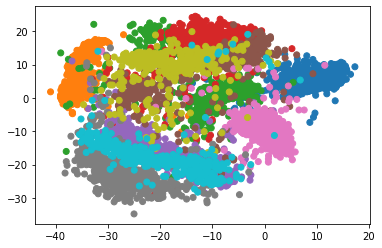

In [15]:
emb = dr.model(testdata.cuda()).detach().cpu()
plt.scatter(
    x=emb[:,0],
    y=emb[:,1],
    c=[ plt.get_cmap('tab10')(t) for t in testtargets ]
)

In [152]:
import seaborn as sns

In [161]:
paradime_colors = {
    "yellow": "#ffcc00",
    "teal": "#144447",
    "cyan": "#23c7a2",
    "red": "#ed3d3d",
    "brown": "#9d6700",
    "purple": "#9a6095",
    "green": "#4c9900", #"#61b60e",
    "orange": "#fd771e",
    "pink": "#f9adc3",
    "grey": "#a1a39d",
    "background": "#fcfcfc",
}
paradime_palette = sns.color_palette(
    [ paradime_colors[i] for i in [
        "teal", "yellow", "cyan", "red", "pink",
        "green", "brown", "grey", "purple", "orange",
    ] ], 10)

In [93]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [129]:
paradime_palette

[(0.0784313725490196, 0.26666666666666666, 0.2784313725490196),
 (1.0, 0.8, 0.0),
 (0.13725490196078433, 0.7803921568627451, 0.6352941176470588),
 (0.9294117647058824, 0.23921568627450981, 0.23921568627450981),
 (0.9764705882352941, 0.6784313725490196, 0.7647058823529411),
 (0.2980392156862745, 0.6, 0.0),
 (0.615686274509804, 0.403921568627451, 0.0),
 (0.6313725490196078, 0.6392156862745098, 0.615686274509804),
 (0.6039215686274509, 0.3764705882352941, 0.5843137254901961),
 (0.9921568627450981, 0.4666666666666667, 0.11764705882352941)]

In [159]:
plt.rcParams['axes.facecolor'] = paradime_colors['background']
plt.rcParams['savefig.facecolor'] = paradime_colors['background']

In [67]:
emb2 = dr.model.embed((mnist.data.reshape(-1, 28*28) / 255.).cuda()).detach().cpu()

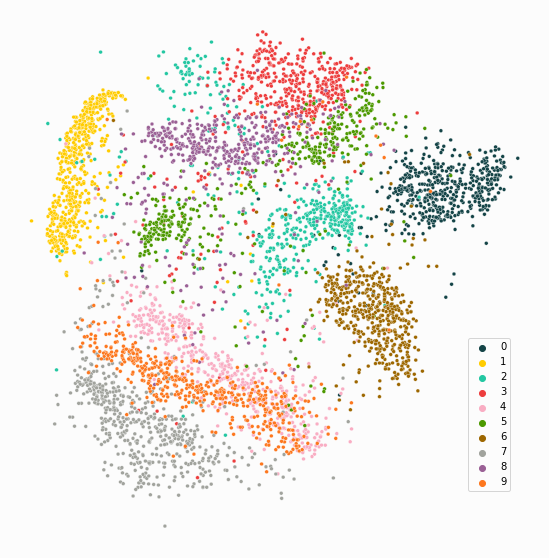

In [164]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

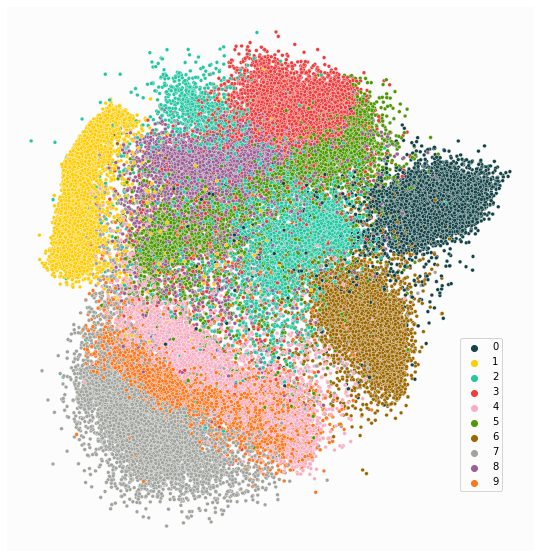

In [165]:
plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb2[:,0], y=emb2[:,1], hue=mnist.targets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))